# Kaggle - Porte Seguro Safe Driver Prediction - Baseline Model
**Author: Chris Shin**

In [1]:
import pandas as pd

train = pd.read_csv('./data/train.csv', index_col='id')
test = pd.read_csv('./data/test.csv', index_col='id')
submission = pd.read_csv('./data/sample_submission.csv', index_col='id')

In [2]:
# Combine all data but taking out target for data processing and feature engineering
all_data = pd.concat([train, test], ignore_index=True)
all_data.drop('target', axis=1, inplace=True)

In [3]:
all_features = all_data.columns
all_features

Index(['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin'],
      dtype='obj

# Categorical Feature One-Hot Encoding
From EDA we decided to keep all categorical features. We will perform one hot encoding for all categorical features

In [4]:
from sklearn.preprocessing import OneHotEncoder

cat_features = [feature for feature in all_features if 'cat' in feature]

onehot_encoder = OneHotEncoder()
encoded_cat_matrix = onehot_encoder.fit_transform(all_data[cat_features])
encoded_cat_matrix

<1488028x184 sparse matrix of type '<class 'numpy.float64'>'
	with 20832392 stored elements in Compressed Sparse Row format>

In [31]:
cat_encoded_features = onehot_encoder.get_feature_names_out(cat_features)

After encoding we have total 184 features

-------------------------
Features to remove based on EDA:

Considered weak features:
- `ps_ind_10_bin`, `ps_ind_11_bin`, `ps_ind_12_bin`, `ps_ind_13_bin`, `ps_ind_14`

High Correlation:
- `ps_car_12` and `ps_car_14` -> `ps_car_14`
- `ps_reg_02` and `ps_reg_03` -> `ps_reg_03`

In [5]:
drop_features = ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin',
                 'ps_ind_14', 'ps_car_14', 'ps_reg_03']

remaining_features = [feature for feature in all_features
                      if('cat' not in feature and
                         'calc' not in feature and
                         feature not in drop_features)]

In [6]:
from scipy import sparse

all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data[remaining_features]),
                               encoded_cat_matrix],
                              format='csr')

In [30]:
all_data_sprs

<1488028x200 sparse matrix of type '<class 'numpy.float64'>'
	with 36140946 stored elements in Compressed Sparse Row format>

In [8]:
num_train = len(train)

X = all_data_sprs[:num_train]
X_test = all_data_sprs[num_train:]

y = train['target'].values

# Evaluation Metrics

Before we move into model training, we need to define the evaluation metrics first. In this Kaggle project, scoring metrics used to evaluate the submission is Normalized Gini Coefficient. The Normalized Gini coefficient is how far away we are with our sorted actual values from a random state measured in number of swaps. Since it is normalized, the range of coefficient is normalized into value of 0 to 1. Thus when it close to 0, performance is bad, and when it close to 1, the performance is good.

<img src="./image/Gini_Index.png" alt="Gini Coefficient Plot" />
source:https://www.nature.com/articles/s41598-019-54288-7

In terms of machine learning, normalized gini coefficient is

Normalized Gini Coefficient = Gini Coefficient of Predicted values / Gini Coefficient of Perfect Predictions

Gini Coefficient of Predicted values = Gini Coefficient calculated with predicted values and actual values

Gini Coefficient of Perfect Predictions = Gini Coefficient calculated with actual values and actual values

In [9]:
import numpy as np

def eval_gini(y_true, y_pred):
    # checking if the preds and actuals have same size
    assert y_true.shape == y_pred.shape

    # number of data
    n_samples = y_true.shape[0]
    # Get diagonal data
    L_mid = np.linspace(1 / n_samples, 1, n_samples)

    # 1) Gini Coefficient on Predictions
    pred_order = y_true[y_pred.argsort()] 
    L_pred = np.cumsum(pred_order) / np.sum(pred_order)
    G_pred = np.sum(L_mid - L_pred) 

    # 2) Gini Coefficient on Actual values (when predictions perfect)
    true_order = y_true[y_true.argsort()] 
    L_true = np.cumsum(true_order) / np.sum(true_order)
    G_true = np.sum(L_mid - L_true)

    return G_pred / G_true

def gini(preds, dtrain):
    # get dataset's target values -> actual values
    labels = dtrain.get_label()
    # return with name of evaluation metric, evaluation scores, and indication of whether scoring is good or bad.
    # For now, we will set True as default as it is baseline model
    return 'gini', eval_gini(labels, preds), True 

--------------------------
--------------------------
# Model Training

### Out of Fold Prediction

OOF prediction, out of fold prediction, is a method of predicting with test data for each fold while performing K-fold cross-validation. We perform K-fold cross-validation, and for each fold we follow below three actions.
- 1) train the model with training data
- 2) measure model performance with validation data
- 3) predict the final target probability with test data

It's not just a one-time prediction with a trained model. It is a method of making multiple predictions with the model for each fold and averaging them.

**OOF Process Steps:**
1. Divide the entire training data into K groups.
2. One of the K groups is designated as validation data and the remaining K-1 groups as training data.
3. Train the model with training data.
4. Using the trained model, we predict target probabilities with validation data and target probabilities with full test data.
5. Record the predicted probability obtained from the validation data and the predicted probability obtained from the test data.
6. If you change the verification data to another group, repeat steps 2 to 5 a total of K times.
7. Calculate the performance score by comparing the probability predicted by K groups of validation data with the actual target value of the training data. This number can be used to measure the performance of the model.
8. Averages the K prediction probabilities from the test data. This value is the final predicted probability

**Then What is the benefit of using OOF?**
- It has the effect of preventing overfitting. Because of the K-fold method of evaluation, the training and validation data are different. Since performance is evaluated on data that has not been encountered during training, it is easy to gauge how well it will generalize to new data. This means that it is easy to respond to overfitting.
- It has Ensemble effects which can improve model performance. An ensemble is a technique that combines the predictions of two or more models trained on the same training dataset. Instead of making one prediction with a single model, K models make K predictions and average them. Probabilities averaged over K predictions are usually more accurate than those predicted only once.

--------------------------
We will use LightGMB for the baseline model

In [10]:
from sklearn.model_selection import StratifiedKFold

# We use stratifiedKFold since data is inbalance
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1991)

In [11]:
# For baseline model simplified the parameter
params = {'objective': 'binary',
          'learning_rate': 0.01,
          'force_row_wise': True,
          'random_state': 0}

In [12]:
# A one-dimensional array containing the probability of predicting the 
# target value of the verification data with the model trained by the OOF method
oof_val_preds = np.zeros(X.shape[0]) 

# A one-dimensional array containing the probability of predicting
# the test data target value with a model trained by the OOF method
oof_test_preds = np.zeros(X_test.shape[0]) 

In [13]:
import lightgbm as lgb
from lightgbm import early_stopping
from lightgbm import log_evaluation

# Train, validate, and predict models in an OOF way
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    # Output a phrase that identifies each fold
    print('#'*40, f'fold {idx+1} / fold {folds.n_splits}', '#'*40)
    
    # Train data
    X_train, y_train = X[train_idx], y[train_idx]
    # Validation data
    X_valid, y_valid = X[valid_idx], y[valid_idx]

    # Convert them to LightGBM dataset
    dtrain = lgb.Dataset(X_train, y_train)
    dvalid = lgb.Dataset(X_valid, y_valid)


    lgb_model = lgb.train(params=params,
                          train_set=dtrain,
                          num_boost_round=1000,
                          valid_sets=dvalid,
                          feval=gini,
                          callbacks=[early_stopping(stopping_rounds=100),
                                     log_evaluation(100)])
    
    # OOF prediction using test data
    oof_test_preds += lgb_model.predict(X_test)/folds.n_splits
    
    # Prediction of validation data target value for model performance evaluation
    oof_val_preds[valid_idx] += lgb_model.predict(X_valid)
    
    # Normalized Gini coefficient for prediction probability of validation data
    gini_score = eval_gini(y_valid, oof_val_preds[valid_idx])
    print(f'fold {idx+1} gini coefficient : {gini_score}\n')

######################################## fold 1 / fold 5 ########################################
[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Total Bins 840
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 199
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764
[LightGBM] [Info] Start training from score -3.274764
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.153387	valid_0's gini: 0.259491
[200]	valid_0's binary_logloss: 0.15245	valid_0's gini: 0.275356
[300]	valid_0's binary_logloss: 0.152023	valid_0's gini: 0.283355
[400]	valid_0's binary_logloss: 0.15182	valid_0's gini: 0.287067
[500]	valid_0's binary_logloss: 0.151724	valid_0's gini: 0.288696
[600]	valid_0's binary_logloss: 0.151698	valid_0's gini: 0.289196
[700]	valid_0's binary_logloss: 0.151695	valid_0's gini: 0.289163
Early stopping, best iteration is:
[608]	valid

In [14]:
print('OOF validation prediction gini coefficient:', eval_gini(y, oof_val_preds))

OOF validation prediction gini coefficient: 0.2808785337196325


In [15]:
submission['target'] = oof_test_preds
submission.to_csv('submission.csv')

For the result we got public score of 0.28415 and private score of 0.27967

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

def plotImp(model, features , num = 20, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':features})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

In [26]:
len(lgb_model.feature_importance())

200

In [37]:
lgbm_features = list(cat_encoded_features) + remaining_features

In [38]:
len(lgbm_features)

200

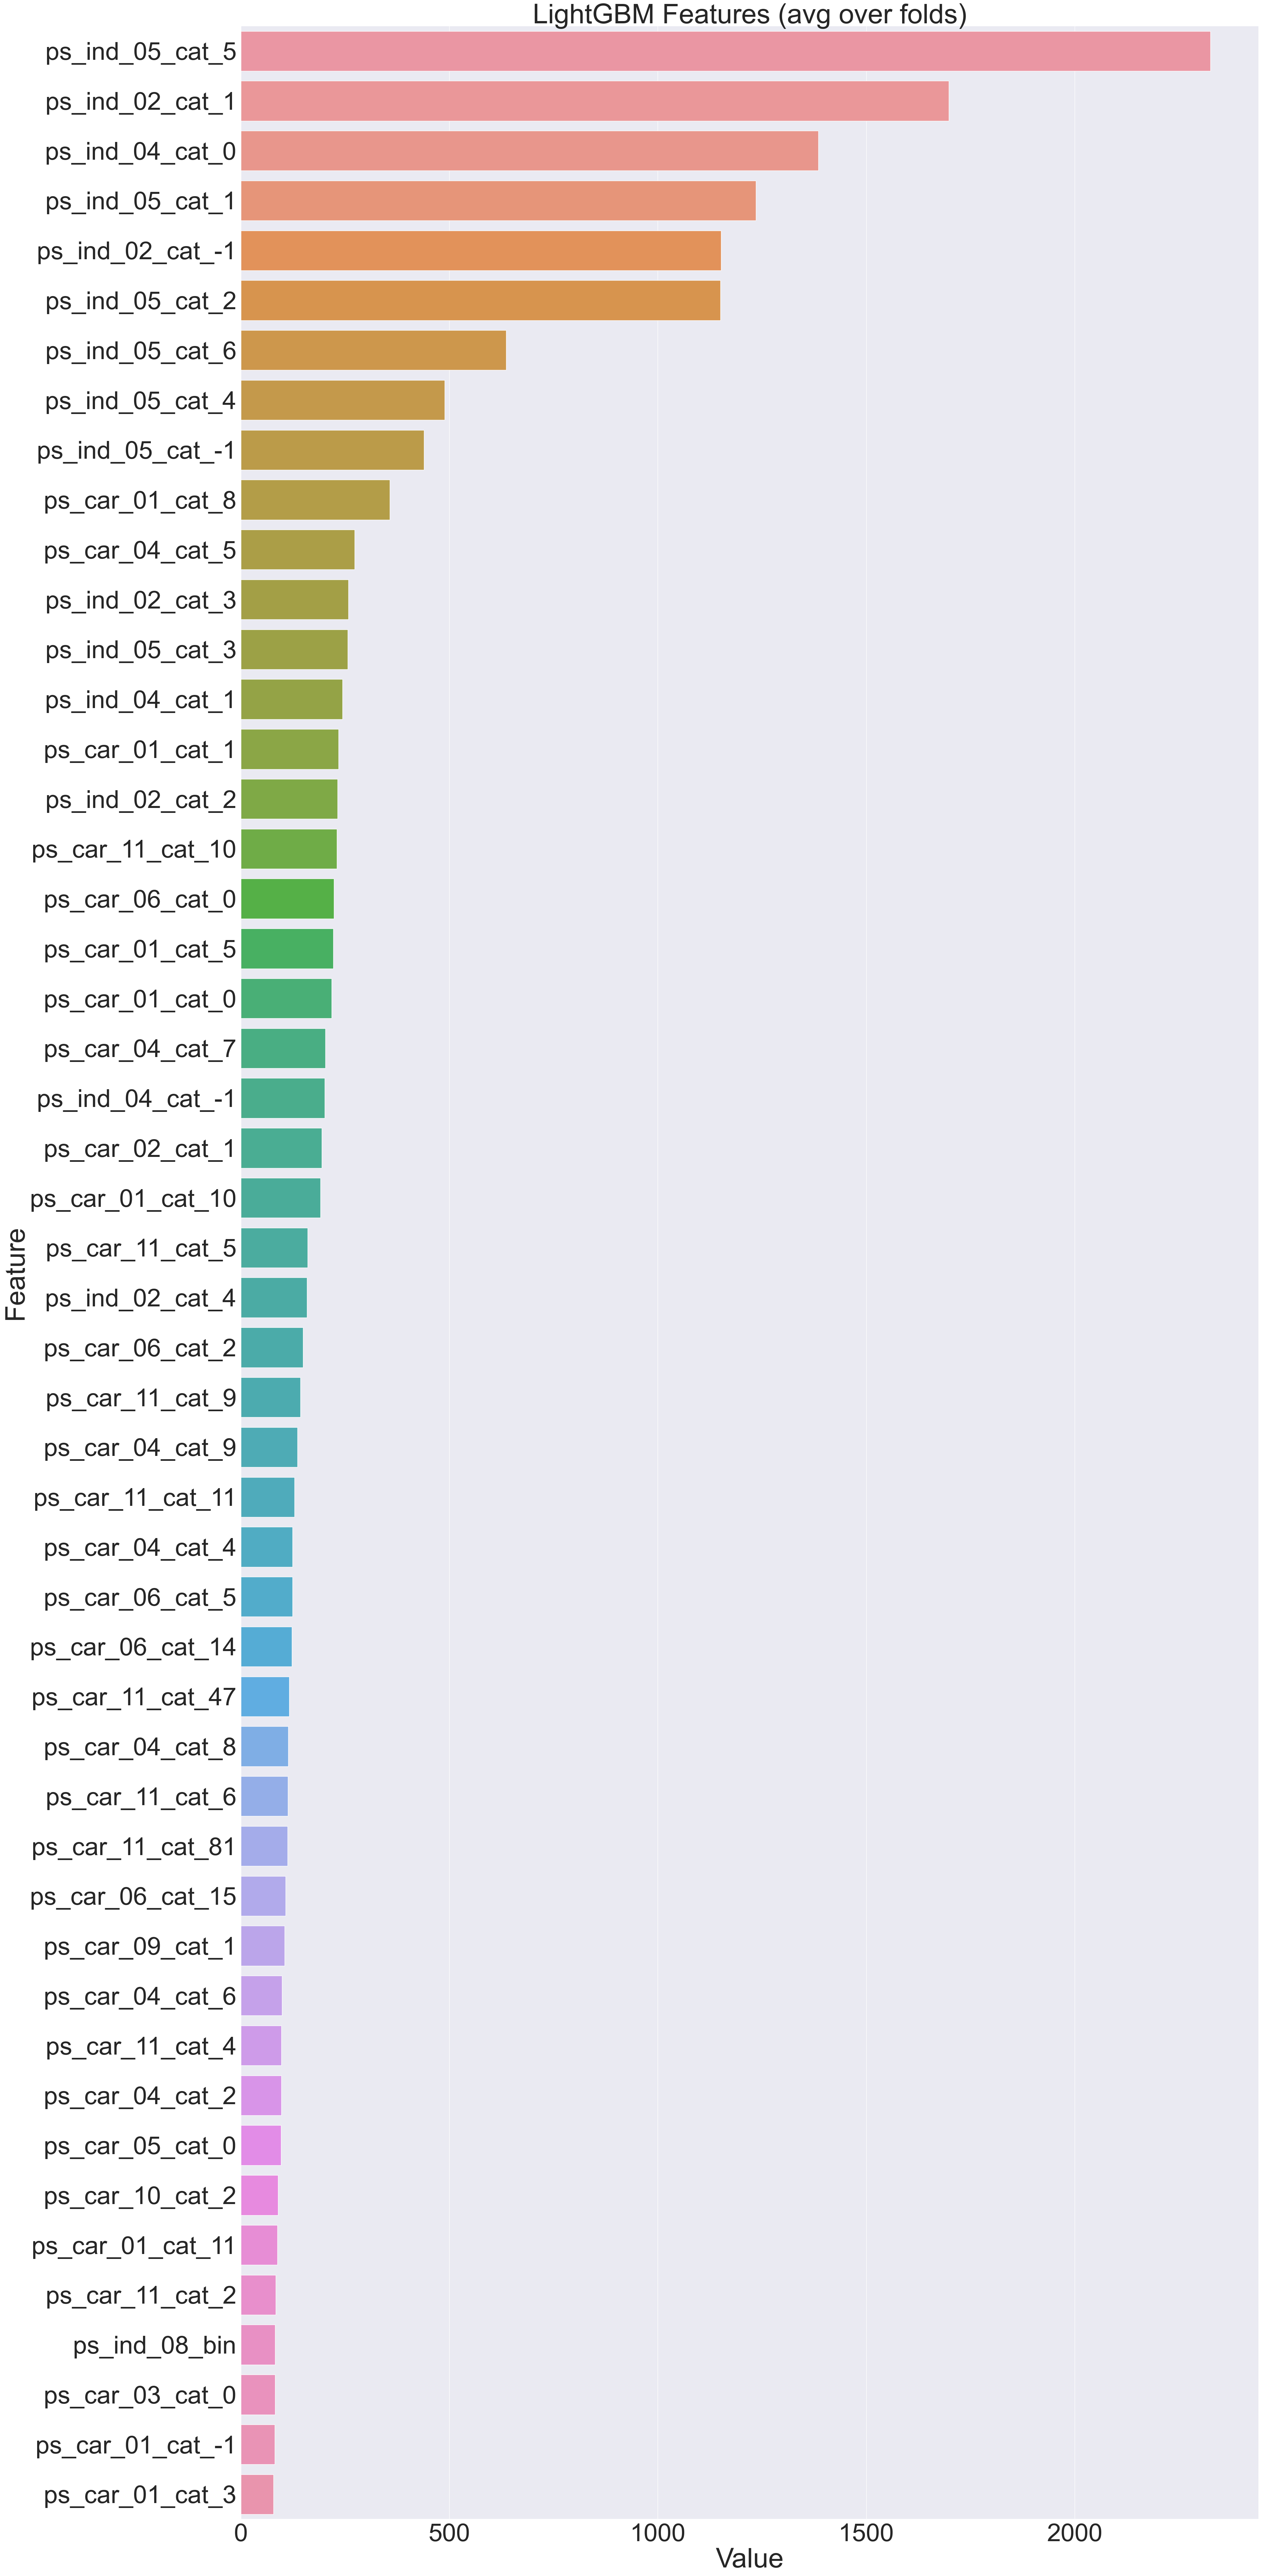

In [42]:
plotImp(lgb_model, lgbm_features, 50, (40, 80))

In [43]:
y

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [50]:
oof_val_preds

array([0.03846069, 0.03137999, 0.02117009, ..., 0.02276077, 0.0263913 ,
       0.02376711])

In [51]:
y_pred = []
for x in oof_val_preds:
    if x < 0.5:
        y_pred.append(0)
    else:
        y_pred.append(1)

In [52]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 96.35%


Confusion matrix:
 [[573513      5]
 [ 21692      2]]


Text(0.5, 1.0, 'Confusion Matrix')

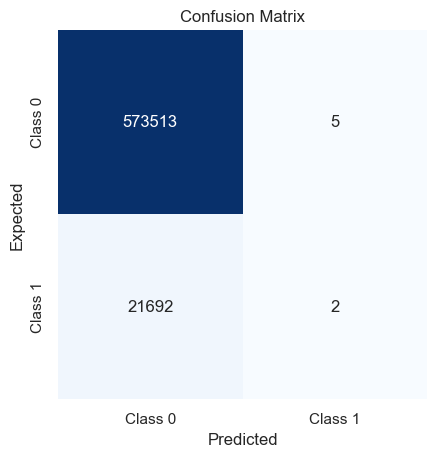

In [63]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y, y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']

sns.heatmap(conf_mat, square=True, annot=True, cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels, fmt='g')
 
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.title("Confusion Matrix")

# TODO
- Additional Features Engineering?
    - Seems like Categories are important and good as it is
    - Seems like binary, ordinal, and continuous features little weak compare to the category features
    - Think of combining or transforming binaries and ordinal?
- Maybe we should try other sampling method?
    - We used StratifiedKFold but maybe using oversampling or SMOTE might helpful for the training